In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

from util.zonotope import TorchZonotope
from util.constrained_zonotope import TorchConstrainedZonotope
from util.NN_controller_dynamics_reach import forward_pass_NN_controller_dynamics_torch
from util.containment_loss import dynamic_NN_contain_step

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Network Setup

In [3]:
# Leaky ReLU gradient
c_a = 0.1  # Controller NN gradient
d_a = 0.01  # Dynamics NN gradient

class ctrlNet(nn.Module):

    def __init__(self):
        super(ctrlNet, self).__init__()
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(2, 2)  
        self.fc2 = nn.Linear(2, 1)  

    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), c_a)
        x = self.fc2(x)
        return x

c_net = ctrlNet()    

class dynNet(nn.Module):

    def __init__(self):
        super(dynNet, self).__init__()
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(3, 5)  
        self.fc2 = nn.Linear(5, 5)
        self.fc3 = nn.Linear(5, 1)

    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), d_a)
        x = F.leaky_relu(self.fc2(x), d_a)
        x = self.fc3(x)
        return x
    
d_net = dynNet()

c_net.to(device)
d_net.to(device)

dynNet(
  (fc1): Linear(in_features=3, out_features=5, bias=True)
  (fc2): Linear(in_features=5, out_features=5, bias=True)
  (fc3): Linear(in_features=5, out_features=1, bias=True)
)

In [4]:
# The dynamics network's already defined and we're not changing it
d_net.fc1.weight.data = torch.tensor([[1.3678e-01,  2.6583e+00,  2.6871e-02], [-1.6930e-01, -3.2784e+00, -3.2101e-02], [1.0481e+00, -8.1330e-02, -1.4924e-03], [-1.0566e+00, -5.6257e-02, -1.7557e-03], [-2.4300e+00, -4.6630e-03, -3.2614e-03]])
d_net.fc2.weight.data = torch.tensor([[-0.0193,  0.0144, -0.5928, -0.3275,  0.3526], [0.8516, -0.6921,  0.0356,  0.0806,  0.3512], [0.0264, -0.0225, -4.8005,  1.9079, -3.0005], [-0.0285,  0.0216, -0.8664, -0.5514,  1.0016], [0.0238, -0.0221,  0.7724,  1.8361, -2.8571]])
d_net.fc3.weight.data = torch.tensor([[0.0908,  0.4370,  0.1354, -0.0952, -0.1029]])
d_net.fc1.bias.data = torch.tensor([4.1136, -5.0725, -2.0897, 2.1067, -2.0784])
d_net.fc2.bias.data = torch.tensor([3.3570, 9.9509, -2.3821, 3.2146, -2.2343])
d_net.fc3.bias.data = torch.tensor([0.1328])

dNN_weights = [torch.tensor([[1.3678e-01,  2.6583e+00,  2.6871e-02], [-1.6930e-01, -3.2784e+00, -3.2101e-02], [1.0481e+00, -8.1330e-02, -1.4924e-03], [-1.0566e+00, -5.6257e-02, -1.7557e-03], [-2.4300e+00, -4.6630e-03, -3.2614e-03]]), torch.tensor([[-0.0193,  0.0144, -0.5928, -0.3275,  0.3526], [0.8516, -0.6921,  0.0356,  0.0806,  0.3512], [0.0264, -0.0225, -4.8005,  1.9079, -3.0005], [-0.0285,  0.0216, -0.8664, -0.5514,  1.0016], [0.0238, -0.0221,  0.7724,  1.8361, -2.8571]]), torch.tensor([[0.0908,  0.4370,  0.1354, -0.0952, -0.1029]])]
dNN_biases = [torch.tensor([[4.1136], [-5.0725], [-2.0897], [2.1067], [-2.0784]]), torch.tensor([[3.3570], [9.9509], [-2.3821], [3.2146], [-2.2343]]), torch.tensor([[0.1328]])]

# Define Variables

In [5]:
x_star = torch.tensor([np.pi, 0]).to(device)
u_star = torch.tensor([0]).to(device)

d_out_star = d_net(torch.cat((x_star, u_star))).detach()

delta_t = 0.005  # timestep

In [6]:
# input zonotope
Z_in = TorchZonotope(torch.zeros(2,1).to(device),torch.eye(2).to(device))

# zonotope to be contained in
c_obs = torch.tensor([[0.],[0.]]).to(device)
G_obs = torch.tensor([[3., 0., 0., 0.],[0., 3., 0., 0.]]).to(device)
A_obs = torch.tensor([[3., 0., -1., 0.],[0., 3., 0., -1.]]).to(device)
b_obs = torch.tensor([[0.],[0.]]).to(device)
Z_obs = TorchConstrainedZonotope(c_obs, G_obs, A_obs, b_obs)  # This is equivalent to input zonotope

# Before Training

Text(0.5, 1.0, 'Input Samples')

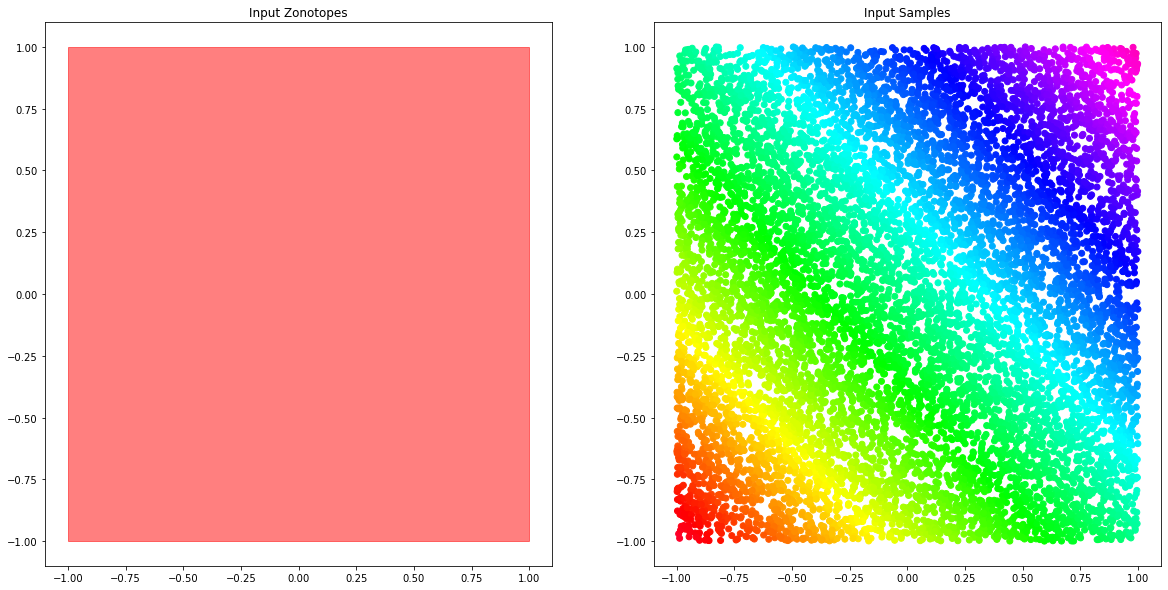

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
Z_obs.plot(ax1, 'r')
ax1.set_title('Input Zonotopes')

# plot samples
N_samples = 10000
X_in = np.random.uniform(-1, 1, (N_samples,2))
X_in = torch.as_tensor(X_in, dtype=torch.float).to(device)
color_vec = torch.sum(X_in[:,:2],dim=1).cpu()
ax2.scatter(X_in[:,0].cpu(), X_in[:,1].cpu(),c=color_vec,cmap="gist_rainbow")
ax2.set_title('Input Samples')

/Users/edgar314/Documents/Personal/ASL_2021_Summer/LReL-reach-training/util/NN_controller_dynamics_reach.py:11: OptimizeWarning: Solving system with option 'cholesky':True failed. It is normal for this to happen occasionally, especially as the solution is approached. However, if you see this frequently, consider setting option 'cholesky' to False.
  res = linprog(f_cost, A_ineq, b_ineq, A_eq, b_eq, (None, None))
/Users/edgar314/Documents/Personal/ASL_2021_Summer/LReL-reach-training/util/NN_controller_dynamics_reach.py:11: OptimizeWarning: Solving system with option 'sym_pos':True failed. It is normal for this to happen occasionally, especially as the solution is approached. However, if you see this frequently, consider setting option 'sym_pos' to False.
  res = linprog(f_cost, A_ineq, b_ineq, A_eq, b_eq, (None, None))
/Users/edgar314/opt/anaconda3/envs/reach-net/lib/python3.8/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=2.9414e-18): resu

/Users/edgar314/opt/anaconda3/envs/reach-net/lib/python3.8/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=4.14002e-19): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/Users/edgar314/opt/anaconda3/envs/reach-net/lib/python3.8/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.20591e-19): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/Users/edgar314/opt/anaconda3/envs/reach-net/lib/python3.8/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=6.73323e-20): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/Users/edgar314/opt/anaconda3/envs/reach-net/lib/python3.8/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.61524e-20): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/Users/edgar314/opt/anaconda

/Users/edgar314/opt/anaconda3/envs/reach-net/lib/python3.8/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.97012e-19): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/Users/edgar314/opt/anaconda3/envs/reach-net/lib/python3.8/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=8.87251e-20): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/Users/edgar314/opt/anaconda3/envs/reach-net/lib/python3.8/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=6.99777e-20): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/Users/edgar314/opt/anaconda3/envs/reach-net/lib/python3.8/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=8.19957e-20): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/Users/edgar314/opt/anaconda

/Users/edgar314/opt/anaconda3/envs/reach-net/lib/python3.8/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=4.61696e-20): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/Users/edgar314/opt/anaconda3/envs/reach-net/lib/python3.8/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=5.37128e-20): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/Users/edgar314/opt/anaconda3/envs/reach-net/lib/python3.8/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=5.97991e-20): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/Users/edgar314/opt/anaconda3/envs/reach-net/lib/python3.8/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=4.99019e-20): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/Users/edgar314/opt/anaconda

/Users/edgar314/opt/anaconda3/envs/reach-net/lib/python3.8/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=3.73201e-20): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/Users/edgar314/opt/anaconda3/envs/reach-net/lib/python3.8/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=5.34074e-20): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/Users/edgar314/opt/anaconda3/envs/reach-net/lib/python3.8/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=2.2123e-19): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/Users/edgar314/opt/anaconda3/envs/reach-net/lib/python3.8/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=6.66628e-20): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/Users/edgar314/opt/anaconda3

/Users/edgar314/opt/anaconda3/envs/reach-net/lib/python3.8/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=8.3527e-19): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


Iter  0
Iter  1
Iter  2
Iter  3
Iter  4
Iter  5
Iter  6
Iter  7
Iter  8
Iter  9
Iter  10
Iter  11
Iter  12
Iter  13
Iter  14
Iter  15
Iter  16
Iter  17
Iter  18
Iter  19
Iter  20


Text(0.5, 1.0, 'Output Samples')

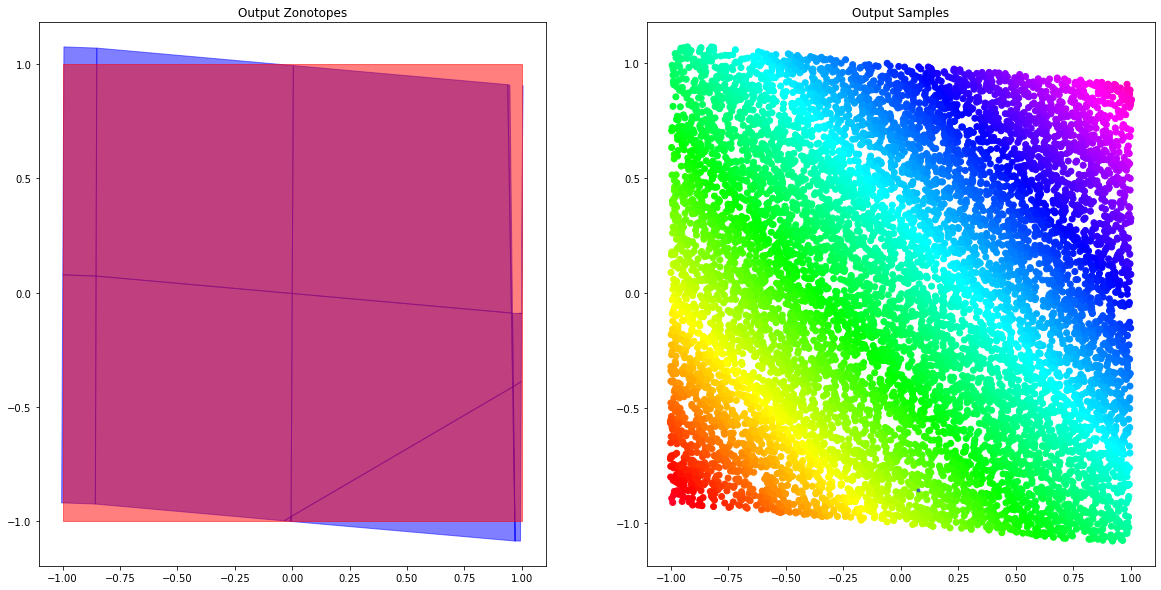

In [8]:
Z_out = forward_pass_NN_controller_dynamics_torch(Z_in, c_net, d_net, x_star, u_star, delta_t, c_a, d_a)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
i = 0
for z in Z_out:
    print('Iter ', i)
    i = i + 1
    z.plot(ax1)
Z_obs.plot(ax1, 'r')

ax1.set_title('Output Zonotopes')
u = c_net(X_in) - c_net(x_star) + u_star
v_next = d_net(torch.cat((X_in, u), 1)) - d_out_star
q_next = (X_in[:, 0] + (X_in[:, 1] + v_next.T) * delta_t * 0.5).T
Y_out = torch.cat((q_next, v_next), 1)
ax2.scatter(Y_out[:,0].cpu().detach().numpy(), Y_out[:,1].cpu().detach().numpy(),c=color_vec,cmap="gist_rainbow")
ax2.set_title('Output Samples')

# Training

In [9]:
# REGULAR TRAINING
# # Use nonlinear function to generate data
# # nonlinear function (vectorized)
# def f_nonl(x):
#     return np.array([x[:,0]**2 + np.sin(x[:,1]),
#                      x[:,1]**2 + np.sin(x[:,0])])

# # training set
# N_train = 10000
# X_train = np.random.uniform(-1, 1, (N_train,2))

# # compute y's
# Y_train = f_nonl(X_train)

# X_train = torch.as_tensor(X_train, dtype=torch.float).to(device)
# Y_train = torch.as_tensor(Y_train.T, dtype=torch.float).to(device)

In [10]:
# # objective optimizer
# obj_opt = optim.SGD(c_net.parameters(), lr=0.1)

# obj = nn.MSELoss()

con_opt = optim.SGD(c_net.parameters(), lr=0.000000001)

num_iters = 5

torch.autograd.set_detect_anomaly(True)

# training loop:
for i in range(num_iters):
#     obj_opt.zero_grad()  # zero the gradient buffers
    
#     u = c_net(X_train) - c_net(x_star) + u_star
#     v_next = d_net(torch.cat((X_train, u), 1)) - d_out_star
#     q_next = (X_train[:, 0] + (X_train[:, 1] + v_next.T) * delta_t * 0.5).T
#     pred = torch.cat((q_next, v_next), 1)
    
#     obj_loss = obj(pred, Y_train)
#     obj_loss.backward()
#     obj_opt.step() 
    dynamic_NN_contain_step(Z_in, Z_obs, c_net, d_net, x_star, u_star, delta_t, con_opt, c_a, d_a)
    
    
print('loss: ', obj_loss)

/Users/edgar314/opt/anaconda3/envs/reach-net/lib/python3.8/site-packages/diffcp/cone_program.py:282: UserWarning: Solved/Inaccurate.
  warnings.warn("Solved/Inaccurate.")


loss:  tensor(0.1595, grad_fn=<AddBackward0>)


/Users/edgar314/opt/anaconda3/envs/reach-net/lib/python3.8/site-packages/torch/autograd/__init__.py:145: UserWarning: Error detected in SvdHelperBackward. Traceback of forward call that caused the error:
  File "/Users/edgar314/opt/anaconda3/envs/reach-net/lib/python3.8/runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/Users/edgar314/opt/anaconda3/envs/reach-net/lib/python3.8/runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "/Users/edgar314/opt/anaconda3/envs/reach-net/lib/python3.8/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/edgar314/opt/anaconda3/envs/reach-net/lib/python3.8/site-packages/traitlets/config/application.py", line 845, in launch_instance
    app.start()
  File "/Users/edgar314/opt/anaconda3/envs/reach-net/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 612, in start
    self.io_loop.start()
  File "/Users/edgar314/opt/anaconda3/envs/r

RuntimeError: Function 'SvdHelperBackward' returned nan values in its 0th output.

# Plotting

Text(0.5, 1.0, 'Trained Outputs')

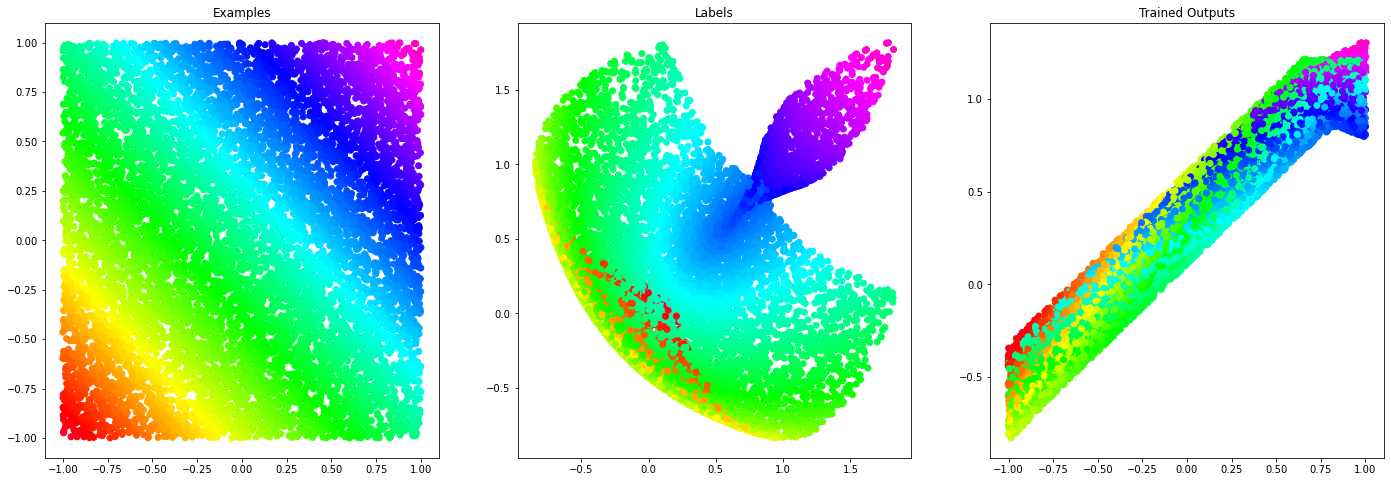

In [12]:
u = c_net(X_train) - c_net(x_star) + u_star
v_next = d_net(torch.cat((X_train, u), 1)) - d_out_star
q_next = (X_train[:, 0] + (X_train[:, 1] + v_next.T) * delta_t * 0.5).T
Y_pred = torch.cat((q_next, v_next), 1)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24,8))
color_vec = torch.sum(X_train[:,:2],dim=1).cpu()
ax1.scatter(X_train[:,0].cpu(), X_train[:,1].cpu(),c=color_vec,cmap="gist_rainbow")
ax1.set_title('Examples')
ax2.scatter(Y_train[:,0].cpu(), Y_train[:,1].cpu(),c=color_vec,cmap="gist_rainbow")
ax2.set_title('Labels')
ax3.scatter(Y_pred[:,0].cpu().detach().numpy(), Y_pred[:,1].cpu().detach().numpy(),c=color_vec,cmap="gist_rainbow")
ax3.set_title('Trained Outputs')